## Project 10 - Marketing Strategy - Part 2

### Notebook Content

1. Dataset Sampling
2. Models Training and Evaluation


## 1. Dataset Sampling
---

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score 

from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [10]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

Import filtered dataset:

In [2]:
train = pd.read_csv('dataset/ds_train.csv')
test = pd.read_csv('dataset/ds_test.csv')

In [3]:
X_train = train.drop(columns='deposit')            
y_train = train['deposit']

X_test = test.drop(columns='deposit')            
y_test = test['deposit']

Checking size and formats:

In [4]:
print('X_train shape: {}, type: {}'.format(X_train.shape, type(X_train)))
print('y_train shape: {}, type: {}'.format(y_train.shape,type(y_train)))
print('X_test shape: {}, type: {}'.format(X_test.shape,type(X_test)))
print('y_test shape: {}, type: {}'.format(y_test.shape,type(y_test)))

X_train shape: (6239, 16), type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (6239,), type: <class 'pandas.core.series.Series'>
X_test shape: (2657, 16), type: <class 'pandas.core.frame.DataFrame'>
y_test shape: (2657,), type: <class 'pandas.core.series.Series'>


Confusion Matrix plotting function:

In [5]:
def plot_cm(y_pred_):                    
    cnf_matrix = confusion_matrix(y_test, y_pred_)
    plt.figure(figsize=(4,3))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    plt.ylabel('Actual Label', size=7)
    plt.xlabel('Predicted Label', size=7)
    plt.show()    

Classification Report function:

In [6]:
def class_report(y_pred_):                                                        
    print(classification_report(y_test, y_pred_, target_names = ['not risk','risk']))

## 2. Models Training and Evaluation
---

In [16]:
xgb = XGBClassifier(objective='binary:logistic',random_state=0)

In [17]:
cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

In [18]:
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [19]:
xgb_cv = GridSearchCV(xgb, cv_params,scoring=scoring,cv=5,refit='f1')

In [20]:
xgb_cv = xgb_cv.fit(X_train,y_train)
xgb_cv

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', scoring={'recall', 'f1', 'precision', 'accuracy'})

In [21]:
pickle.dump(xgb_cv,open('xgb_cv.sav','wb'))

In [22]:
y_pred = xgb_cv.predict(X_test)

In [25]:
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.8407978923598043
precision score: 0.8054662379421221
recall score: 0.8469991546914624
f1 score: 0.8257107540173052


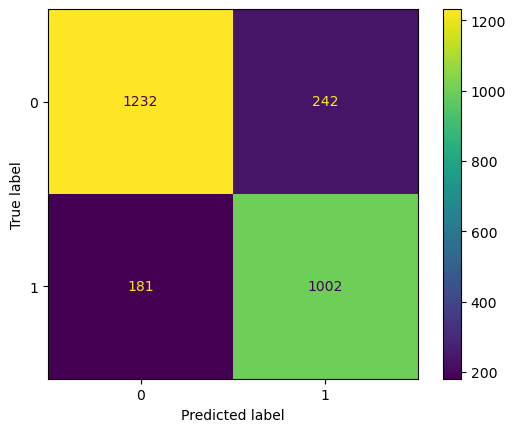

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)
disp.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

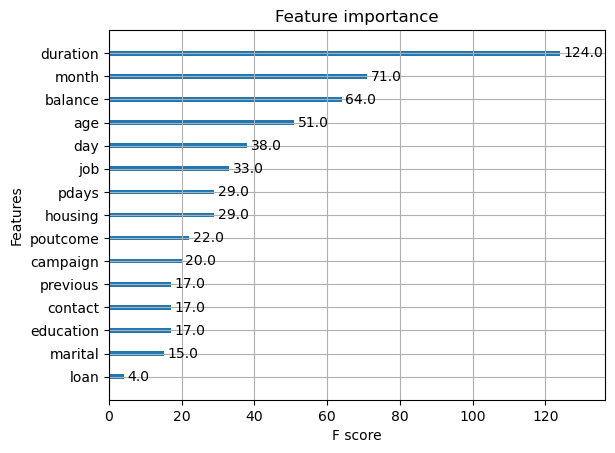

In [27]:
plot_importance(xgb_cv.best_estimator_)